In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
!pip install catboost

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.3 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Load the data
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Carbon_Uniaxial_PI.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,...,Mn,P,S,Ni,Cr,Cu,Method,Test Type,Dataset,PI Fatigue Life
0,1,400,25400,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,6.142922e+02
1,1,380,38800,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,1.264736e+04
2,1,380,48100,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,1.264736e+04
3,1,370,77200,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,6.095369e+04
4,1,370,152000,600,825,0.05,0.03,0.0,120,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,6.095369e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,24,400,63000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,4.216358e+04
202,24,380,165000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,2.812306e+05
203,24,380,300000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,2.812306e+05
204,24,360,1030000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,2.078500e+06


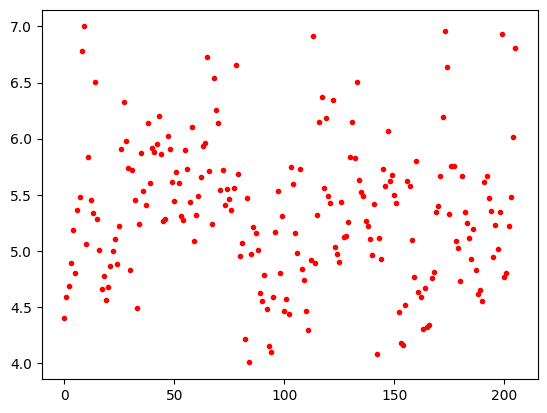

In [ ]:
# Scatter plot
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
fatigue_df.columns

Index(['Heat', 'Stress (Mpa)', 'Number of Cycles', 'Temperature (°C)',
       'Reduction Ratio', 'dA', 'dB', 'dC', 'Frequency', 'Elongation',
       'Reduction of Area', 'C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Cu',
       'Method', 'Test Type', 'Dataset', 'PI Fatigue Life'],
      dtype='object')

In [ ]:
# Remove columns that are not needed
drop_cols = ['Heat','Number of Cycles','Method','Dataset'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# One-hot encoding the 'Test Type' column
features = pd.get_dummies(features, columns=['Test Type'], prefix='Test Type')

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life,Test Type_repeated,Test Type_reversed
0,490,600,1740,0.07,0.00,0.0,20,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,7.020612e+03,False,True
1,520,600,1750,0.07,0.00,0.0,20,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,7.256881e+03,False,True
2,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,1.254765e+04,False,True
3,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,1.254765e+04,False,True
4,520,600,1270,0.08,0.01,0.0,20,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,9.634130e+03,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,340,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,1.722116e+07,True,False
202,350,600,1740,0.07,0.00,0.0,120,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,7.016572e+06,True,False
203,360,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,2.078500e+06,True,False
204,365,600,1750,0.07,0.00,0.0,120,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,7.211075e+06,True,False


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
        return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

q: 0.025 | pearsonr: 0.7130585258312979
q: 0.5 | pearsonr: 0.8224382297354516
q: 0.975 | pearsonr: 0.7047594070800852
Pearson CC: 0.8224382297354516
R2 score: 0.6732237318921379
RMSE: 0.32556416203467237
MAE: 0.23851191402428581
Coverage: 92.85714285714286
Upper coverage: 92.85714285714286
Lower coverage: 100.0
Average Interval Width: 1.97356595404088
Median Interval Width: 1.9512803977176123
Composite Metric: 0.824549573562566


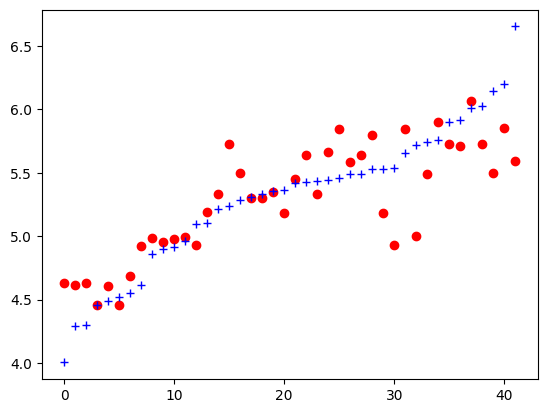

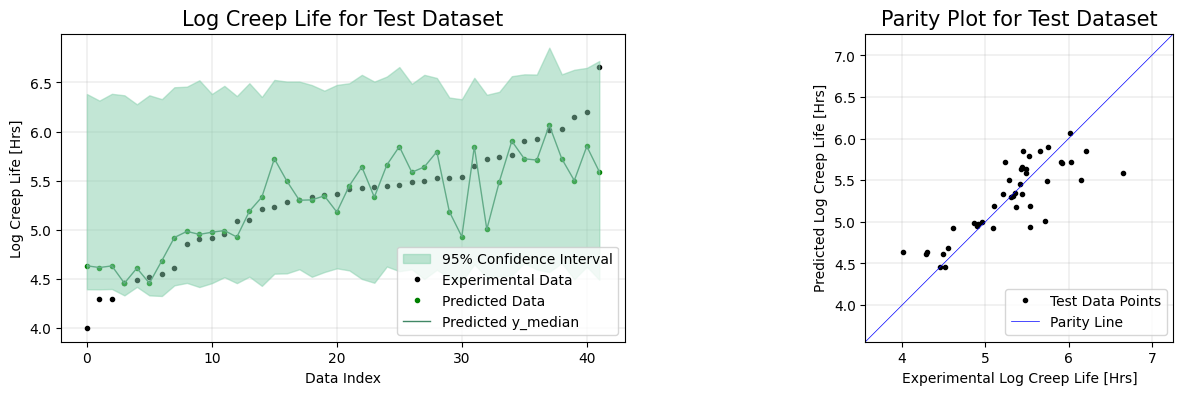

****************************************
q: 0.025 | pearsonr: 0.6294820399802575
q: 0.5 | pearsonr: 0.8212340303749429
q: 0.975 | pearsonr: 0.7471711155818468
Pearson CC: 0.8212340303749429
R2 score: 0.6478687044364051
RMSE: 0.3984564010369684
MAE: 0.2811989048534768
Coverage: 82.92682926829269
Upper coverage: 100.0
Lower coverage: 82.92682926829269
Average Interval Width: 1.2904986791243016
Median Interval Width: 1.2602465120857707
Composite Metric: 0.8203251071623483


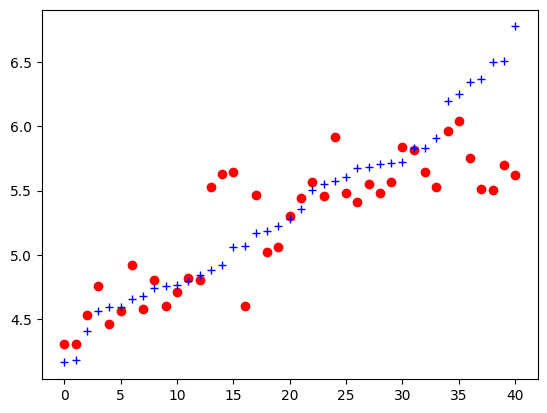

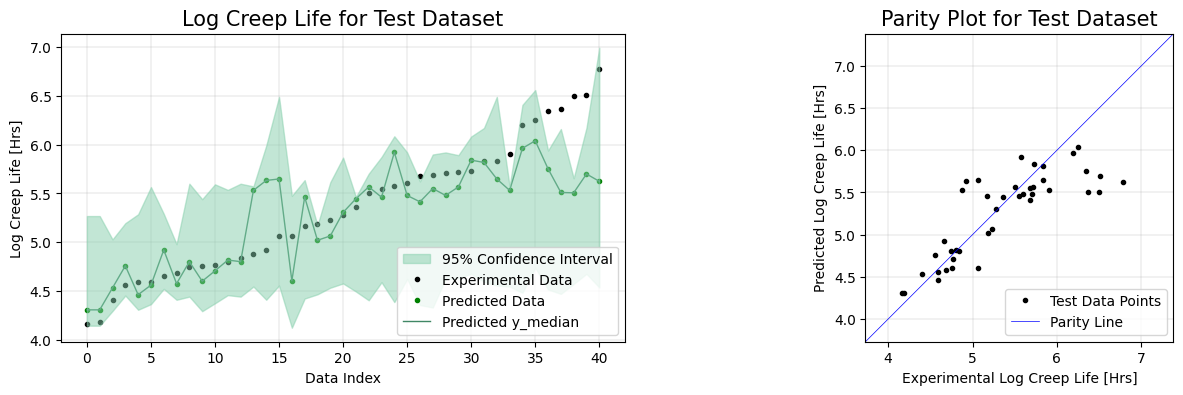

****************************************
q: 0.025 | pearsonr: 0.8156262091094806
q: 0.5 | pearsonr: 0.8782764549857037
q: 0.975 | pearsonr: 0.7463097494117505
Pearson CC: 0.8782764549857037
R2 score: 0.6493003296005984
RMSE: 0.31772911848210666
MAE: 0.24882945002426538
Coverage: 100.0
Upper coverage: 100.0
Lower coverage: 100.0
Average Interval Width: 1.95168997258159
Median Interval Width: 1.9372981934236524
Composite Metric: 0.8790456992365189


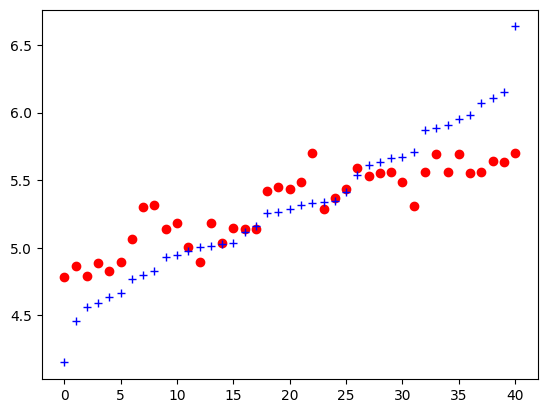

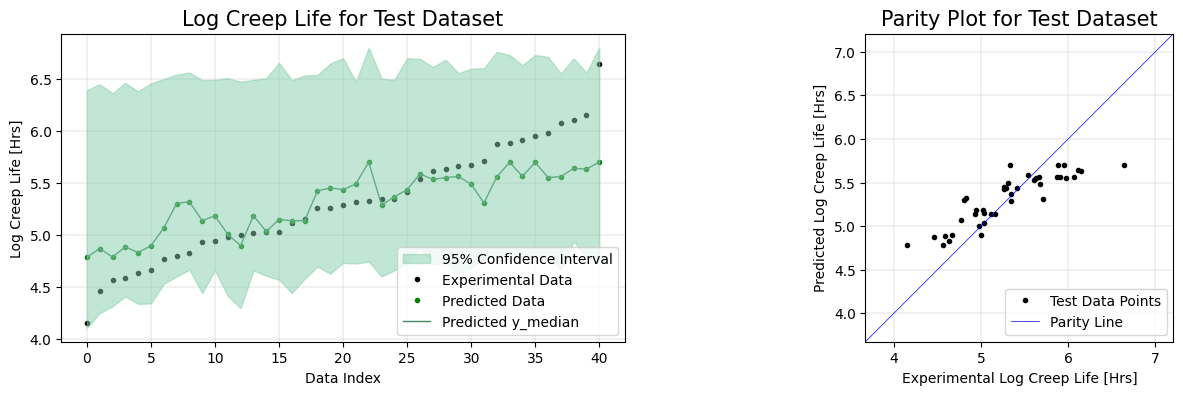

****************************************
q: 0.025 | pearsonr: 0.5949146015798797
q: 0.5 | pearsonr: 0.774876050565134
q: 0.975 | pearsonr: 0.6876729868934663
Pearson CC: 0.774876050565134
R2 score: 0.5623908336562544
RMSE: 0.4036114447125999
MAE: 0.2822696040005857
Coverage: 82.92682926829269
Upper coverage: 97.5609756097561
Lower coverage: 85.3658536585366
Average Interval Width: 1.6307644090011184
Median Interval Width: 1.63053059411709
Composite Metric: 0.7752755428349181


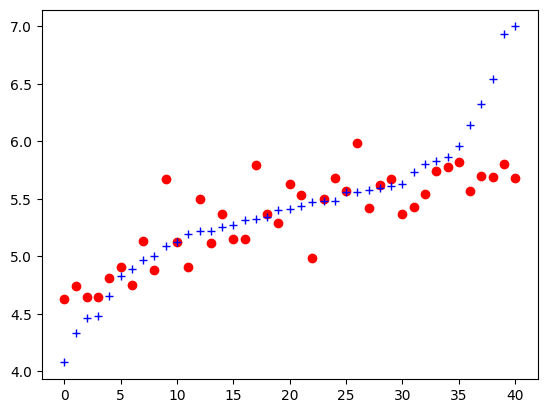

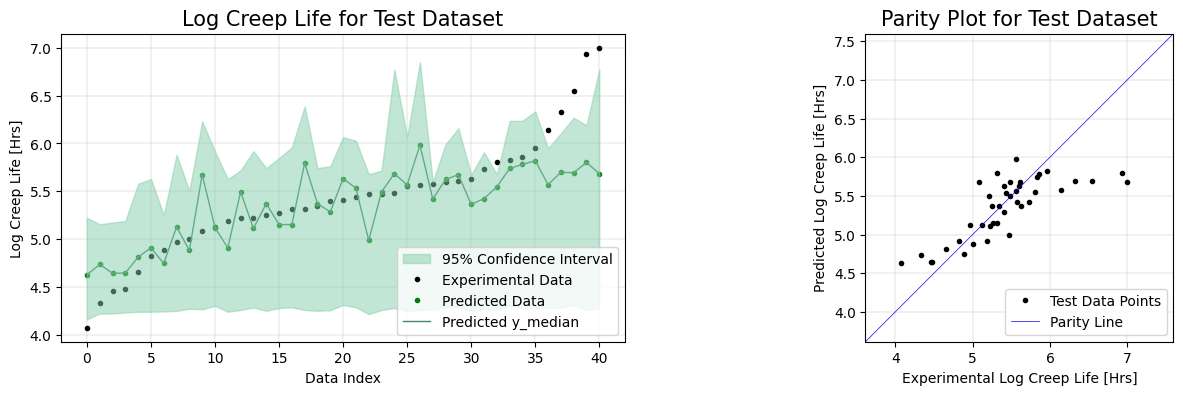

****************************************
q: 0.025 | pearsonr: 0.7834009585477404
q: 0.5 | pearsonr: 0.8612393868499844
q: 0.975 | pearsonr: 0.8392509383393385
Pearson CC: 0.8612393868499844
R2 score: 0.6902440048118361
RMSE: 0.39212601528004065
MAE: 0.26478479245894565
Coverage: 73.17073170731706
Upper coverage: 82.92682926829269
Lower coverage: 90.2439024390244
Average Interval Width: 1.0496155082008327
Median Interval Width: 1.0152502032311252
Composite Metric: 0.7950252058106981


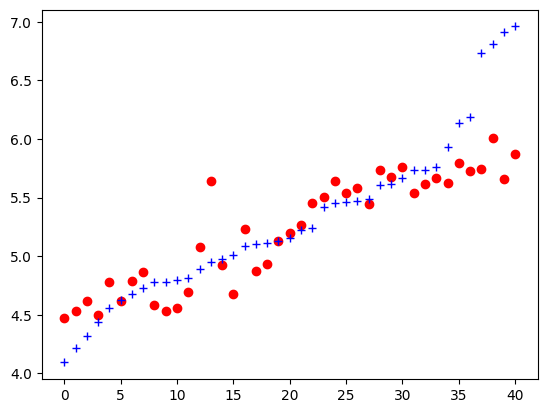

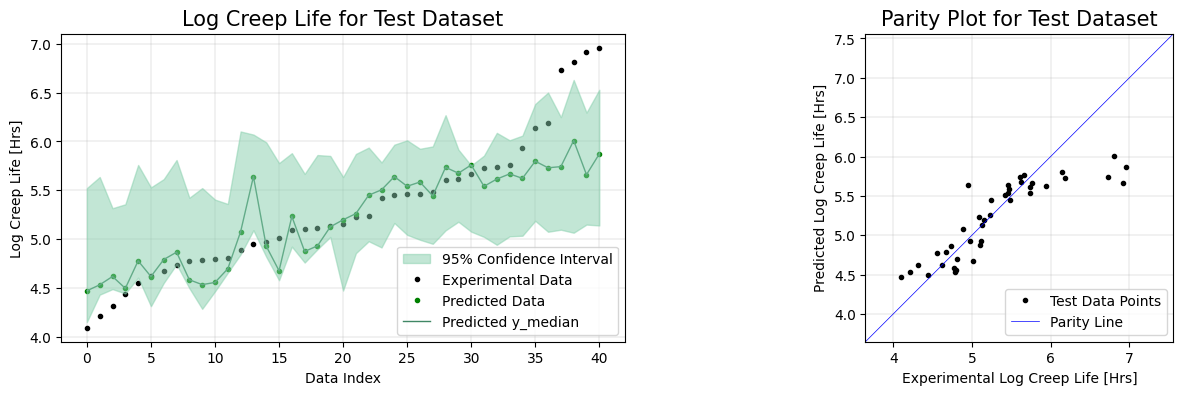

****************************************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

quantiles = [0.025, 0.5, 0.975]

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=66+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):
                X_train, X_test = features.iloc[tr], features.iloc[ts]
                scale = StandardScaler()
                X_train = scale.fit_transform(X_train)
                X_test = scale.transform(X_test)
                y_train, y_test = targets.iloc[tr], targets.iloc[ts]
                X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=0.1)

                for q in quantiles:
                        parameters = {'loss_function': 'Quantile:alpha={:0.2f}'.format(q),
                                'num_boost_round': 5000}
                        model = CatBoostRegressor(**parameters)
                        model.fit(X_train, np.log(y_train),
                                eval_set=[(X_val, np.log(y_val))],
                                early_stopping_rounds=20,
                                verbose=False)
                        y_pred = np.exp(model.predict(X_test))
                        print(f'q: {q} | pearsonr: {pearsonr(y_test, y_pred)[0]}')
                        if q==0.025:
                           y_low = y_pred
                        elif q==0.5:
                                y_median = y_pred
                        elif q==0.975:
                               y_high = y_pred

                # Plot the predictions
                iteration_list = [i for i in range(len(y_test))]

                plt.plot(iteration_list, y_median, 'ro')
                plt.plot(iteration_list, y_test, 'b+')

                PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_median))[0]
                R2_score[j, i] = r2_score(y_test, y_median)
                RMSE[j, i] = np.sqrt(mean_squared_error(y_test, y_median))
                MAE[j, i] = np.mean(abs(y_median-np.array(y_test)))

                print(f'Pearson CC: {PearsonCC[j, i]}')
                print(f'R2 score: {R2_score[j, i]}')
                print(f'RMSE: {RMSE[j, i]}')
                print(f'MAE: {MAE[j, i]}')

                test_coverage[j, i] = coverage(y_test, y_low, y_high)
                upper_coverage[j, i] = coverage(y_test, y_low, np.inf)
                lower_coverage[j, i] = coverage(y_test, -np.inf, y_high)

                print(f'Coverage: {test_coverage[j, i]}')
                print(f'Upper coverage: {upper_coverage[j, i]}')
                print(f'Lower coverage: {lower_coverage[j, i]}')


                # Prediction interval width
                mean_interval_width[j, i] = np.mean(y_high - y_low)
                print(f'Average Interval Width: {mean_interval_width[j, i]}')
                median_interval_width[j, i] = np.median(y_high - y_low)
                print(f'Median Interval Width: {median_interval_width[j, i]}')

                # Composite metric that combines the coverage and the invers of interval width
                composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
                print(f'Composite Metric: {composite_metric[j, i]}')

                # Plot the predictions
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

                ## Uncertainty quantification plot
                ax[0].fill_between(iteration_list, y_low, y_high, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
                ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
                ax[0].plot(iteration_list, y_median, 'go', markersize=3, label="Predicted Data")
                ax[0].plot(iteration_list, y_median, '-', linewidth=1, color="#408765", label="Predicted y_median")
                ax[0].legend(loc=4, fontsize=10, frameon=True)
                ax[0].set_xlabel("Data Index", fontsize=10)
                ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
                ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
                ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

                ## Parity Plot
                # find the boundaries of y_test and y_pred(y_median) values
                bounds = (min(y_test.min(), y_median.min()) - 0.1*y_median.min(), max(y_test.max(), y_median.max())+ 0.1 * y_median.max())
                ax[1].plot(y_test, y_median, 'ko', markersize=3, label="Test Data Points")
                ax[1].legend(loc=4, fontsize=10, frameon=False)
                ax[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
                ax[1].legend(loc=4, fontsize=10, frameon=True)
                ax[1].set_xlabel("Experimental Log Creep Life [Hrs]", fontsize=10)
                ax[1].set_ylabel("Predicted Log Creep Life [Hrs]", fontsize=10)
                ax[1].set_title("Parity Plot for Test Dataset", fontsize=15)
                ax[1].grid(True, which='major', linestyle='-', linewidth='0.25')
                ax[1].set_xlim(bounds)
                ax[1].set_ylim(bounds)
                ax[1].set_aspect("equal", adjustable="box") # Square aspect ratio

                plt.show()
                print(40*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.822438,0.673224,0.325564,0.238512
1,0.821234,0.647869,0.398456,0.281199
2,0.878276,0.649300,0.317729,0.248829
3,0.774876,0.562391,0.403611,0.282270
4,0.861239,0.690244,0.392126,0.264785


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
MAPE_mean = np.mean(MAPE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
MAPE_std = np.std(MAPE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   },index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.831613,0.035962,0.644606,0.044031,0.367497,0.037695,0.263119,0.017356


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,92.857143,92.857143,100.000000,1.973566,1.951280,0.824550
1,82.926829,100.000000,82.926829,1.290499,1.260247,0.820325
2,100.000000,100.000000,100.000000,1.951690,1.937298,0.879046
3,82.926829,97.560976,85.365854,1.630764,1.630531,0.775276
4,73.170732,82.926829,90.243902,1.049616,1.015250,0.795025


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,86.376307,9.228123,94.66899,6.424392,91.707317,7.169238,1.579227,0.363522,1.558921,0.370682,0.818844,0.034999
